<a href="https://colab.research.google.com/github/miltiadiss/Decision-Theory/blob/main/Project%202/Counterfeiting_of_banknotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Decision Theory**

#**Project 2: Counterfeiting of banknotes**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Load data and apply Z-Score Normalization on features**

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data from csv
file_path = '/content/drive/MyDrive/data.csv'
data = pd.read_csv(file_path)

# Separate features (X) and target variable (y)
X = data.drop(columns=['class']) # Drop only column 'class' to keep the features
y = data['class'] # Keep only column 'class' which is the target

# Apply Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # Convert the scaled data into a DataFrame

##**Question 1**

###**PCA**


Principal Components:
     variance  skewness  curtosis   entropy
PC1  0.248772  0.639323 -0.612707 -0.392389
PC2  0.754591 -0.050340 -0.153459  0.636010


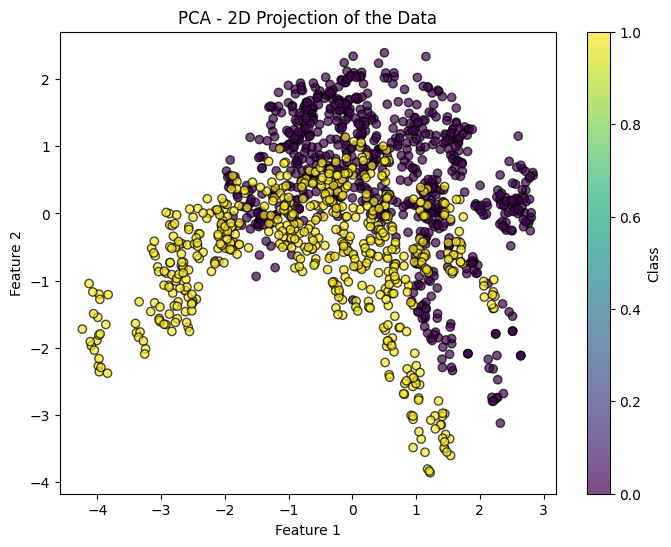

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the number of features to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

# Convert the PCA result into a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Split the data into 60% training, 20% validation, and 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_pca_df, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Display the contribution of each feature to each principal component
print("\nPrincipal Components:")
components_df = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])
print(components_df)

# Plot the PCA features
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(label='Class')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('PCA - 2D Projection of the Data')
plt.show()

###**Parzen Windows**

Bandwidth: 0.1, Training Accuracy: 0.9247, Validation Accuracy: 0.8613
Bandwidth: 0.5, Training Accuracy: 0.8165, Validation Accuracy: 0.8102
Bandwidth: 1.0, Training Accuracy: 0.7922, Validation Accuracy: 0.7883
Bandwidth: 2.0, Training Accuracy: 0.7618, Validation Accuracy: 0.7774
Bandwidth: 5.0, Training Accuracy: 0.7618, Validation Accuracy: 0.7774


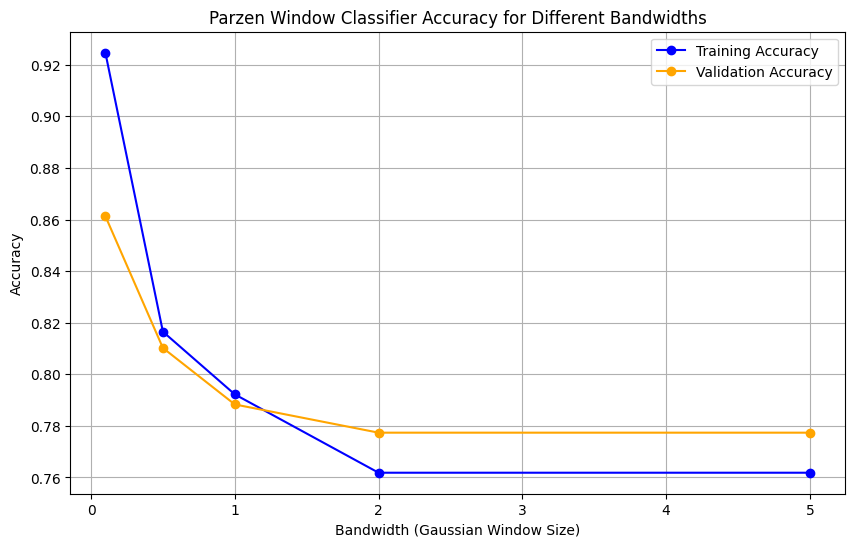

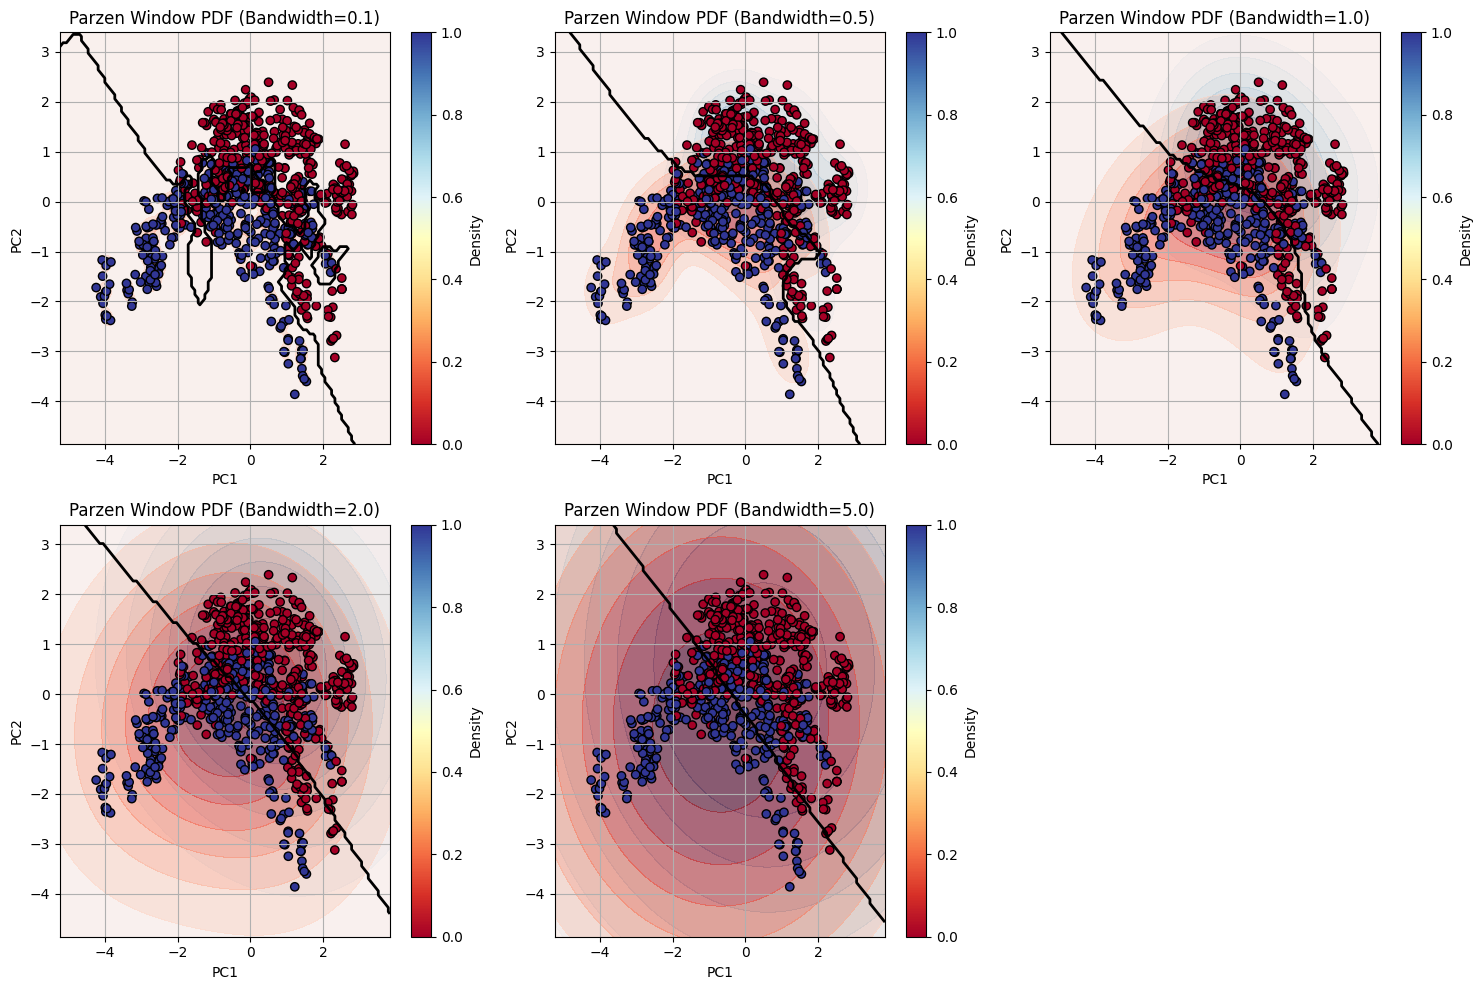

In [5]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parzen Window with Gaussian Kernel
def parzen_window(X_train, y_train, X_test, bandwidth):
    classes = np.unique(y_train)
    predictions = []

    for x_test in X_test.values:
        class_probabilities = []

        for c in classes:
            # Get the training data for the current class
            X_class = X_train[y_train == c]

            # Compute the Parzen window density estimate for the current class
            density = 0
            for x_train in X_class.values:
                # Gaussian kernel
                density += np.exp(-np.linalg.norm(x_test - x_train) ** 2 / (2 * bandwidth ** 2))

            # Normalize the density
            density /= len(X_class)
            class_probabilities.append(density)

        # Classify based on the highest density estimate
        predicted_class = classes[np.argmax(class_probabilities)]
        predictions.append(predicted_class)

    return np.array(predictions)

# Parzen Window with Gaussian Kernel for PDF estimation
def parzen_window_pdf(X_train, y_train, X_test, bandwidth):
    classes = np.unique(y_train)
    pdfs = {c: [] for c in classes}  # Dictionary to store PDFs for each class

    # For each test point, compute the density estimate for each class
    for x_test in X_test.values:
        for c in classes:
            # Get the training data for the current class
            X_class = X_train[y_train == c]

            # Compute the Parzen window density estimate for the current class
            density = 0
            for x_train in X_class.values:
                # Gaussian kernel
                density += np.exp(-np.linalg.norm(x_test - x_train) ** 2 / (2 * bandwidth ** 2))

            # Normalize the density
            density /= len(X_class)
            pdfs[c].append(density)

    return pdfs

# Generate a grid of points for plotting
x_min, x_max = X_train['PC1'].min() - 1, X_train['PC1'].max() + 1
y_min, y_max = X_train['PC2'].min() - 1, X_train['PC2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Bandwidths to evaluate
bandwidths = [0.1, 0.5, 1.0, 2.0, 5.0]

# Store accuracies for training and validation sets
train_accuracies = []
val_accuracies = []

for bandwidth in bandwidths:
    # Predict on training set
    y_train_pred = parzen_window(X_train, y_train, X_train, bandwidth)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Predict on validation set
    y_val_pred = parzen_window(X_train, y_train, X_val, bandwidth)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)

    print(f"Bandwidth: {bandwidth}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(bandwidths, train_accuracies, marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(bandwidths, val_accuracies, marker='o', linestyle='-', label='Validation Accuracy', color='orange')
plt.xlabel('Bandwidth (Gaussian Window Size)')
plt.ylabel('Accuracy')
plt.title('Parzen Window Classifier Accuracy for Different Bandwidths')
plt.legend()
plt.grid(True)
plt.show()

# Plot PDFs for each bandwidth on a grid
plt.figure(figsize=(15, 10))
for bandwidth in bandwidths:
    pdfs = parzen_window_pdf(X_train, y_train, pd.DataFrame(grid_points, columns=['PC1', 'PC2']), bandwidth)
    Z_class_0 = np.array(pdfs[0]).reshape(xx.shape)
    Z_class_1 = np.array(pdfs[1]).reshape(xx.shape)

    plt.subplot(2, 3, bandwidths.index(bandwidth) + 1)
    plt.contourf(xx, yy, Z_class_0, alpha=0.5, cmap='Blues')
    plt.contourf(xx, yy, Z_class_1, alpha=0.5, cmap='Reds')

    # Plot decision boundaries
    decision_boundaries = parzen_window(X_train, y_train, pd.DataFrame(grid_points, columns=['PC1', 'PC2']), bandwidth)
    decision_boundaries = decision_boundaries.reshape(xx.shape)
    plt.contour(xx, yy, decision_boundaries, levels=[0.5], linewidths=2, colors='black')

    # Plot training data points
    plt.scatter(X_train['PC1'], X_train['PC2'], c=y_train, cmap=plt.cm.RdYlBu, edgecolors='k', marker='o')

    plt.title(f'Parzen Window PDF (Bandwidth={bandwidth})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Density')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import f1_score

# Use the Parzen window classifier with the optimal bandwidth h=1
bandwidth = 1.0
y_pred = parzen_window(X_train, y_train, X_test, bandwidth)

# Calculate the F1 score for test set
f1_parzen = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score for Parzen Window: {f1_parzen:.4f}")

F1 Score for Parzen Window: 0.8259


##**Question 2**

##**k-NN**

k: 1, Training Accuracy: 1.0000, Validation Accuracy: 0.8650
k: 3, Training Accuracy: 0.9222, Validation Accuracy: 0.8540
k: 5, Training Accuracy: 0.9125, Validation Accuracy: 0.8577
k: 7, Training Accuracy: 0.8882, Validation Accuracy: 0.8577
k: 9, Training Accuracy: 0.8821, Validation Accuracy: 0.8723
k: 11, Training Accuracy: 0.8821, Validation Accuracy: 0.8723
k: 15, Training Accuracy: 0.8651, Validation Accuracy: 0.8577
k: 20, Training Accuracy: 0.8591, Validation Accuracy: 0.8212


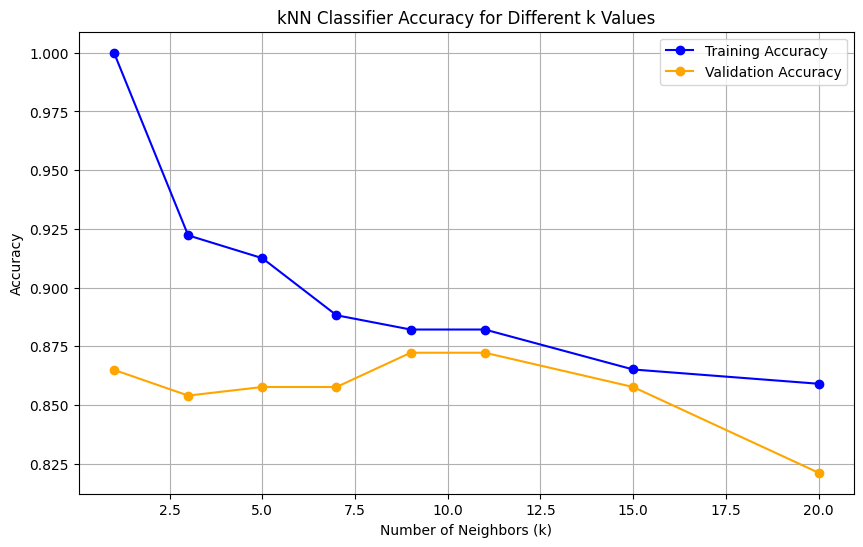

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/pytho

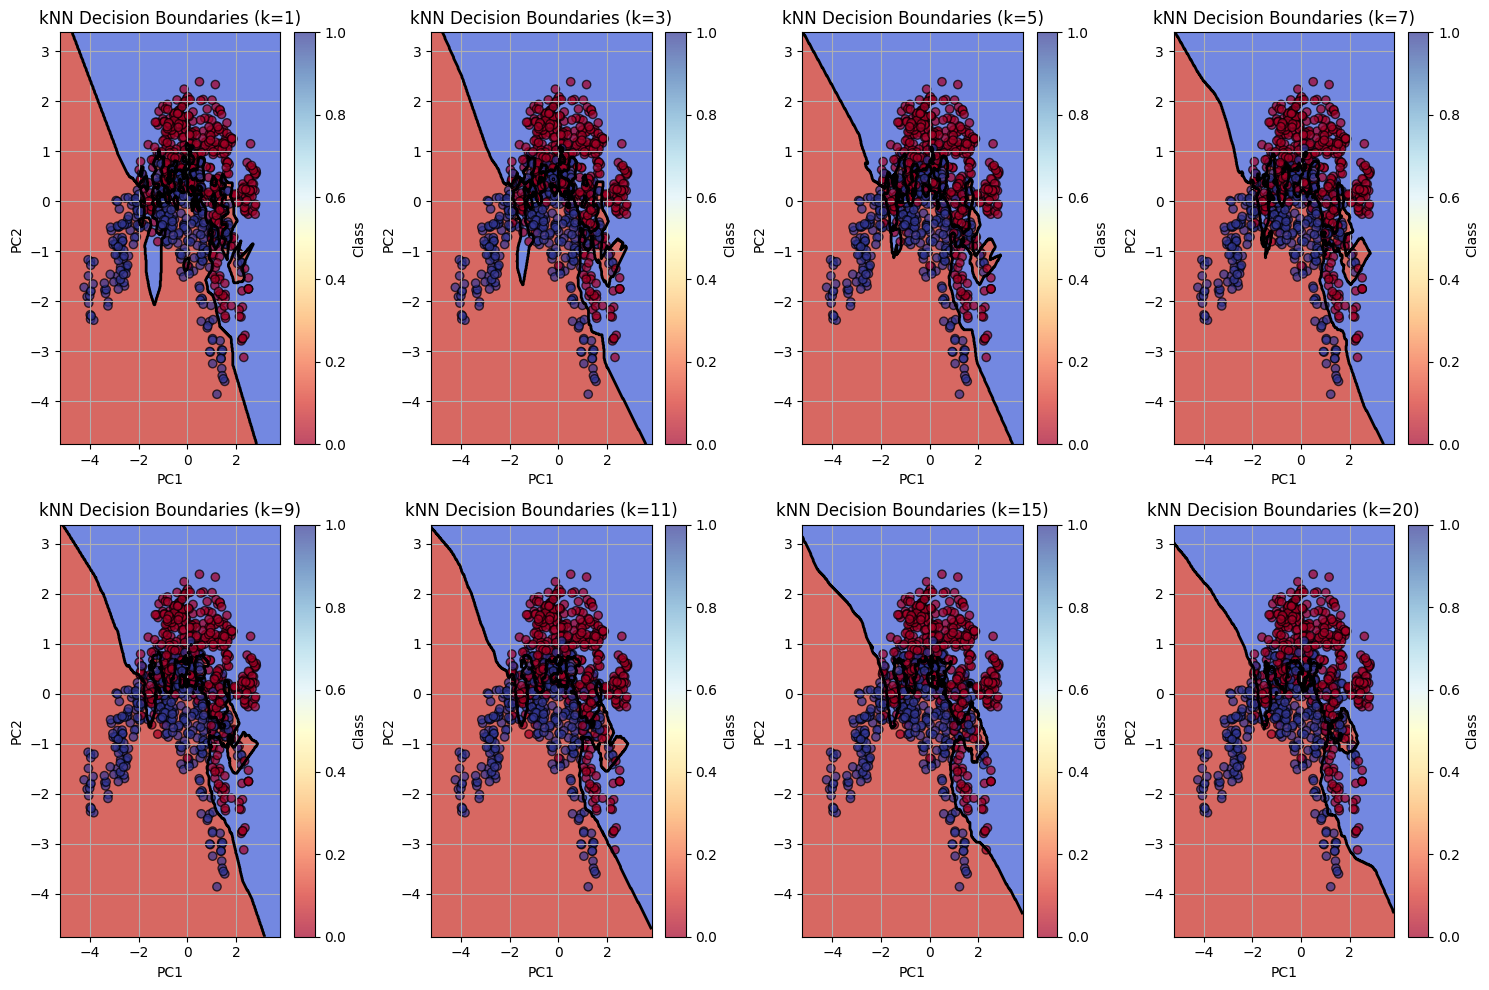

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# Define a range of k values to evaluate
k_values = [1, 3, 5, 7, 9, 11, 15, 20]

# Lists to store accuracies for each k
train_accuracies_knn = []
val_accuracies_knn = []

# Loop over k values
for k in k_values:
    # Initialize kNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model on the training set
    knn.fit(X_train, y_train)

    # Predict on training set
    y_train_pred_knn = knn.predict(X_train)
    train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
    train_accuracies_knn.append(train_accuracy_knn)

    # Predict on validation set
    y_val_pred_knn = knn.predict(X_val)
    val_accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
    val_accuracies_knn.append(val_accuracy_knn)

    print(f"k: {k}, Training Accuracy: {train_accuracy_knn:.4f}, Validation Accuracy: {val_accuracy_knn:.4f}")

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies_knn, marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(k_values, val_accuracies_knn, marker='o', linestyle='-', label='Validation Accuracy', color='orange')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('kNN Classifier Accuracy for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot decision boundaries over different k values
h = 0.02  # Step size in the mesh
x_min, x_max = X_train['PC1'].min() - 1, X_train['PC1'].max() + 1
y_min, y_max = X_train['PC2'].min() - 1, X_train['PC2'].max() + 1

# Create a meshgrid for plotting decision boundaries
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(15, 10))

# Loop through each k value
for idx, k in enumerate(k_values):
    # Initialize kNN classifier with the current k
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict on the meshgrid
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundaries in a subplot
    plt.subplot(2, 4, idx + 1)

    # Plot the decision boundaries using contourf (filled areas)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')

    # Add a contour line to represent the decision boundary
    contour = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors='black')

    # Plot training points with specific color map
    scatter = plt.scatter(X_train['PC1'], X_train['PC2'], c=y_train, cmap='RdYlBu', edgecolors='k', marker='o', alpha=0.7)

    # Title, labels, and grid for the plot
    plt.title(f'kNN Decision Boundaries (k={k})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter, label='Class')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Initialize the kNN classifier
k = 11  # Choose the optimal value of k=11
knn = KNeighborsClassifier(n_neighbors=k)

# Fit the kNN classifier on the PCA-reduced data
knn.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn.predict(X_test)

# Calculate the F1 score for the testing set
f1_kNN = f1_score(y_test, y_pred, average='weighted')  # 'weighted' accounts for class imbalance

# Output the F1 score for the testing set
print(f"F1 Score for k-NN: {f1_kNN:.4f}")

F1 Score for k-NN: 0.8872
